# Finding the edge of one pinture using Quantum Paralelism

This notebook is based on the paper:

[Yao, X.-W.](https://arxiv.org/abs/1801.01465), et al. (2017). Quantum Image Processing and Its Application to Edge Detection: Theory and Experiment. Physical Review X, 7(3), 031041. http://doi.org/10.1103/PhysRevX.7.031041

The main objective of this algorithm is to find the edge of one image. This means, given the image:

<img src="./Images/C.png">

the objective is to find its edges to get this other image:

<img src="./Images/C_EDGES.png">

The algorithm has the next steps:

1. Load the image as a matrix os (n,m) elements $c_{ij}$
$$D=\begin{bmatrix} 
d_{11} & d_{12} & \cdots&d_{1j}&\cdots&d_{1m}  \\
d_{21} & d_{22} & \cdots&d_{2j}&\cdots &d_{2m}  \\
\vdots&&\ddots&\vdots&\ddots&\vdots\\
d_{i1} & d_{i2} & \cdots&d_{ij}&\cdots &d_{im}  \\
\vdots&&\ddots&\vdots&\ddots&\vdots\\
d_{n1} & d_{n2} & \cdots&d_{nj}&\cdots &d_{nm}  \\
\end{bmatrix}$$
2. Convert the array in a vector of N=n\*m elements
$$C=\begin{bmatrix} 
d_{11}   \\
d_{21}   \\
\vdots\\
d_{ij}   \\
d_{(i+1) j}   \\
\vdots\\
d_{nm} \\
\end{bmatrix}=
\begin{bmatrix} 
c_{0}   \\
c_{1}   \\
\vdots\\
c_{N-2}   \\
c_{N-1}   \\
\end{bmatrix}
$$
3. Map this vector to one qureg of $q=log_2(N)$ qubits as
$${\lvert}\phi(C){\rangle}=\frac{1}{{\left\lVert C \right\rVert}^2}\sum_{k=0}^{N-1}c_{k}{\lvert}k{\rangle}$$
4. Apply a Hadamard gate to the last qubit
$$(I^{\otimes q-1}\otimes H)\lvert\phi(C)\rangle=\begin{bmatrix} 
c_{0}+c_{1}   \\
c_{0}-c_{1}   \\
\vdots\\
c_{N-2}+c_{N-1}\\
c_{N-2}-c_{N-1}\\
\end{bmatrix}$$
So, even elements will be close to 0 if two pixels have near values -in the case of black and white images, they must be 0- and will have values different of 0 if they are borders. Measuring the last qubit, if the result is 1, the final states $\lvert k \rangle$ (states representing odd natural numbers), encode the pixels of the boundaries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from numpy import linalg as LA
from qiskit import *
import qiskit.tools.jupyter
%qiskit_version_table

Load the image. Because it is too large, rescale it.

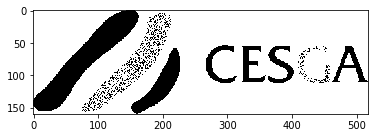

In [2]:
A=Image.open("Images/cesga_unha_tinta.jpg").convert("1")
maxsize=(A.size[0]//4,A.size[1]//4)
A.thumbnail(maxsize, Image.ANTIALIAS)
im_arr = (np.array(A)==False).astype(np.int8)
plt.imshow(im_arr, cmap='Greys' )

Because even after rescaling the image is to large to simulate, crop it around **C**

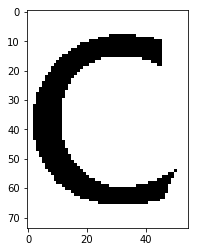

In [3]:
im_crop=im_arr[46:120,265:320]
#im_crop=im_arr[46:60,265:300]
plt.imshow(im_crop, cmap='Greys' )

Calculate the number of qubits needed to store all the image. Remember that n qubits can store $N=2^ n$ complex numbers. As consequence, to store m\*n pixels, a qureg of $q=\log_2(n*m)$ qubits is used

In [4]:
number_of_qubits=int(np.ceil(np.log2(im_crop.shape[0]*im_crop.shape[1])))
print(number_of_qubits)

12


Create a vector with the number of elements that number_of_qubits can store

In [5]:
Vector=np.zeros((2**number_of_qubits))
print("Print %d qubits can store %d elements."%(number_of_qubits,Vector.shape[0]))

Print 12 qubits can store 4096 elements.


Now, map the image to the first elements of this vector

In [6]:
shape=im_crop.shape[0]*im_crop.shape[1]
Vector[0:shape]=im_crop.reshape((shape))

Because the norm of the amplitudes of one quantum state must be one, we must convert this vector to a normalized one, dividing each element by the norm of the vector. 

In [7]:
from numpy import linalg as LA
norma=LA.norm(Vector)
Vnorma=Vector/norma

Allocate one qureg with the number of needed qubits.

In [8]:

circuit=QuantumCircuit(number_of_qubits,number_of_qubits,name="EDGE")
qreg=circuit.qregs[0]

Now, use the operation [Custom](https://qiskit.org/documentation/api/qiskit.aqua.components.initial_states.Custom.html) to generate the quantum circuit to map the Vnorma vector to one quantum state. This operation will generate the set of gates to transform the initial state $\lvert 0 \rangle^{\otimes q}$ to the desired final state $\lvert \phi \rangle$.

In [9]:
from qiskit.aqua.components.initial_states import Custom

In [10]:
import numpy as np
CreateState=Custom(number_of_qubits,state_vector=Vnorma)

In [11]:
inputCir=circuit+CreateState.construct_circuit(mode='circuit', register=qreg)

In [12]:
def Display(string):
    from IPython.display import display, Markdown
    display(Markdown(string))
def VectorToLatex(A,Format='{:.4f}'):
    a="\\begin{bmatrix}"
    for i in range(A.shape[0]):
        a=a+Format.format(A[i])
        a=a+"\\\\"
    a=a+"\\end{bmatrix}"
    return(a)
def MatrixToLatex(A,Format='{:.4f}'):
    a="\\begin{bmatrix}"
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if ((j+1)%A.shape[1])==0:
                a=a+Format.format(A[i,j])
            else:
                a=a+Format.format(A[i,j])+"&"
        if ((i+1)%A.shape[0])!=0:
            a=a+"\\\\"
    a=a+"\\end{bmatrix}"
    return(a)

In [13]:
simulator = Aer.get_backend('statevector_simulator')

# Execute and get counts
result = execute(inputCir.copy(), simulator).result()
statevector = result.get_statevector(inputCir)
#plot_state_city(statevector, title='Bell state')


/home/agomez/.conda/envs/cursoQC/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


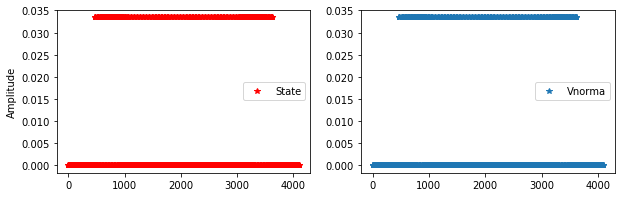

In [14]:
fig,ax=plt.subplots(1,2,figsize=(10,3))
ax[0].plot(statevector,"r*",label="State")
ax[0].legend()
ax[0].set_ylabel("Amplitude")
ax[1].plot(Vnorma,"*",label="Vnorma")
ax[1].legend()

/home/agomez/.conda/envs/cursoQC/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


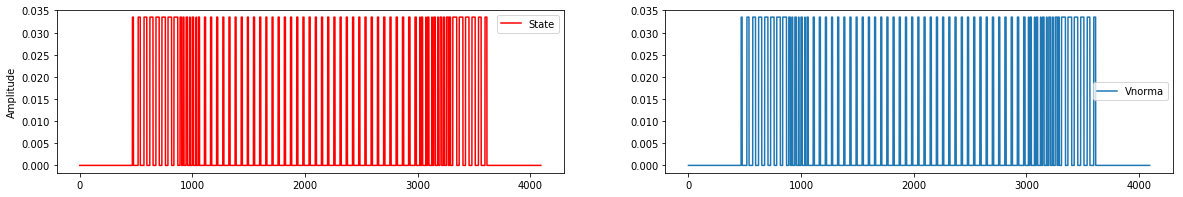

In [15]:
fig,ax=plt.subplots(1,2,figsize=(20,3))
ax[0].plot(statevector,"r-",label="State")
ax[0].legend()
ax[0].set_ylabel("Amplitude")
ax[1].plot(Vnorma,"-",label="Vnorma")
ax[1].legend()

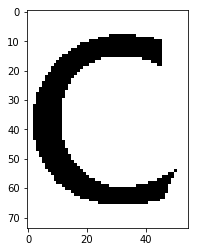

In [16]:
IMOutput=np.round((statevector[0:im_crop.shape[0]*im_crop.shape[1]]).real*norma)
plt.imshow(IMOutput.reshape((im_crop.shape[0],im_crop.shape[1])), cmap='Greys')

Now, apply the Hadamard gate to the last qubit.

In [17]:
inputCir.h(0)

In the real case, a large number of measurements of the final state have to be done to obtain the probabilities of the final state. In fact, the algorithm needs to measure the last qubit and, when the results is one, the result state is the solution.However, in the simulator, you can recover them directly, and take only those that are due to last state equal to 1, this means, the natural odd numbers.

In [18]:
inputCir.measure(inputCir.qregs[0],inputCir.cregs[0])

In [19]:
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(inputCir.copy(), simulator,shots=shape).result()


In [20]:
resultado=result.get_counts(inputCir)

In [21]:
resultado

{'000111010100': 10,
 '000111010110': 11,
 '000111011000': 7,
 '000111011010': 12,
 '000111011101': 1,
 '001000000110': 3,
 '001000001000': 8,
 '001000001010': 7,
 '001000001100': 10,
 '001000001110': 9,
 '001000010000': 6,
 '001000010010': 9,
 '001000010100': 6,
 '001000010110': 8,
 '001000011000': 15,
 '001000111011': 1,
 '001000111100': 8,
 '001000111110': 15,
 '001001000000': 11,
 '001001000010': 10,
 '001001000100': 7,
 '001001000110': 11,
 '001001001000': 11,
 '001001001010': 9,
 '001001001100': 7,
 '001001001110': 11,
 '001001010000': 9,
 '001001010010': 8,
 '001001101111': 3,
 '001001110000': 10,
 '001001110010': 6,
 '001001110100': 4,
 '001001110110': 4,
 '001001111000': 8,
 '001001111010': 6,
 '001001111100': 5,
 '001001111110': 10,
 '001010000000': 8,
 '001010000010': 6,
 '001010000100': 14,
 '001010000110': 9,
 '001010001000': 7,
 '001010001011': 2,
 '001010100100': 3,
 '001010100101': 7,
 '001010100110': 8,
 '001010101000': 7,
 '001010101010': 8,
 '001010101100': 10,
 '001

In [22]:
for i in range(1,2**number_of_qubits,2):
    state=np.binary_repr(i,width=number_of_qubits)
    try:
        print(state,resultado[state])
    except:
        pass

000111011101 1
001000111011 1
001001101111 3
001010001011 2
001010100101 7
001011111001 3
001101000101 2
001101100111 1
001110001001 1
001110110001 2
001111010101 3
001111110011 2
010000011101 2
010011110111 2
010100101101 2
010100110111 6
010101101101 6
010111010001 4
011000000111 6
011000010001 1
011010110101 3
011100011001 5
011100100011 4
011110000111 3
011110010001 2
011111110101 4
011111111111 4
100001100011 6
100001101101 1
100011010001 5
100011011011 1
100100111111 3
100101001001 3
100110000001 3
100111100101 1
100111101111 4
101000100111 1
101010001011 2
101011000011 2
101011001101 1
101100000101 3
101100111101 4
101101101001 2
101101110101 1
101110100001 2
101110101101 1
101111001101 3
101111100101 2
110000000001 4
110000000011 1
110000010001 2
110000011101 4
110001101011 1
110010001111 2
110010011111 3
110010100111 3
110010111001 2
110011001001 3
110011011101 2
110011110001 7
110101001011 1
110110000001 1
110111010101 1
111000001111 2


In [23]:
Vout=np.zeros(shape)

In [24]:
for i in  range(1,shape,2):
    bits=np.binary_repr(i,width=number_of_qubits)
    try:
        Vout[i]=resultado[bits]
        print(bits,resultado[bits])
    except:
        pass

000111011101 1
001000111011 1
001001101111 3
001010001011 2
001010100101 7
001011111001 3
001101000101 2
001101100111 1
001110001001 1
001110110001 2
001111010101 3
001111110011 2
010000011101 2
010011110111 2
010100101101 2
010100110111 6
010101101101 6
010111010001 4
011000000111 6
011000010001 1
011010110101 3
011100011001 5
011100100011 4
011110000111 3
011110010001 2
011111110101 4
011111111111 4
100001100011 6
100001101101 1
100011010001 5
100011011011 1
100100111111 3
100101001001 3
100110000001 3
100111100101 1
100111101111 4
101000100111 1
101010001011 2
101011000011 2
101011001101 1
101100000101 3
101100111101 4
101101101001 2
101101110101 1
101110100001 2
101110101101 1
101111001101 3
101111100101 2
110000000001 4
110000000011 1
110000010001 2
110000011101 4
110001101011 1
110010001111 2
110010011111 3
110010100111 3
110010111001 2
110011001001 3
110011011101 2
110011110001 7
110101001011 1
110110000001 1
110111010101 1
111000001111 2


Text(0.5, 1.0, 'New transformed image')

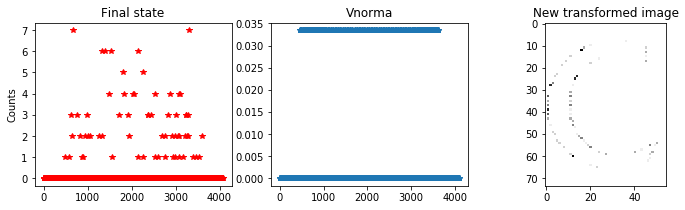

In [25]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
ax[0].plot(Vout,"r*",label="Final state")
ax[0].set_title("Final state")
ax[0].set_ylabel("Counts")
ax[1].plot(Vnorma,"*",label="Vnorma")
ax[1].set_title("Vnorma")
IMOutputOdd=np.round((Vout)*norma)
IMOutput=np.round(Vout*0)
IMOutput[0::2]=IMOutputOdd[1::2]
ax[2].imshow(IMOutput.reshape((im_crop.shape[0],im_crop.shape[1])), cmap='Greys')
ax[2].set_title("New transformed image")

OK. Look the final result after applying a single gate. Remember that only even elements are needed

Only half of the borders have been calculated. To calculate the even borders, the algorithm must be executed permuting the input vector by one position.

In [26]:
Veven=np.take(Vnorma,range(1,len(Vnorma)+1),mode="warp")

In [27]:
circuit=QuantumCircuit(number_of_qubits,number_of_qubits,name="EDGE")
qreg=circuit.qregs[0]
import numpy as np
CreateState=Custom(number_of_qubits,state_vector=Veven)
inputCir=circuit+CreateState.construct_circuit(mode='circuit', register=qreg)
inputCir.h(0)
inputCir.measure(inputCir.qregs[0],inputCir.cregs[0])
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(inputCir.copy(), simulator,shots=shape).result()


In [40]:
resultado=result.get_counts(inputCir)
Vouteven=np.zeros(shape)
for i in  range(1,shape,2):
    bits=np.binary_repr(i,width=number_of_qubits)
    try:
        Vouteven[i]=resultado[bits]
        print(bits,resultado[bits])
    except:
        pass


000111010011 1
001001010011 1
001011000001 5
001100001111 1
001100101111 4
001110011101 3
001110111101 1
010000001001 3
010000001011 4
010000100111 5
010001010011 5
010001011101 5
010010001001 2
010010111111 5
010011001001 1
010011111111 1
010101100011 4
010110011001 1
010110100011 2
010111011001 4
011000111101 3
011001000111 2
011001111101 3
011010101011 2
011011100001 1
011011101011 1
011101001111 3
011101011001 2
011111000111 3
100000101011 1
100000110101 4
100010011001 2
100010100011 1
100100000111 2
100100010001 1
100110101101 2
100110110111 2
101001010011 8
101001011101 3
101010010101 2
101011111001 1
101111001011 4
110000110101 1
110000111001 1
110001010101 1
110001101111 2
110001111111 3
110100010011 1
110100101001 1
110101100001 1
110110110111 1
111000011111 1


Text(0.5, 1.0, 'New transformed image')

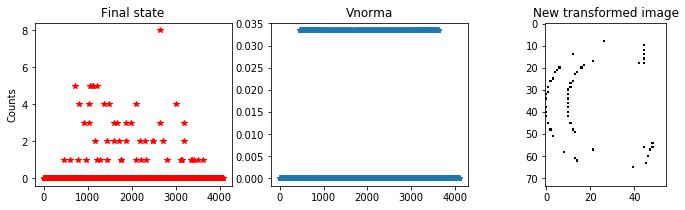

In [41]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
ax[0].plot(Vouteven,"r*",label="Final state")
ax[0].set_title("Final state")
ax[0].set_ylabel("Counts")
ax[1].plot(Vnorma,"*",label="Vnorma")
ax[1].set_title("Vnorma")
IMOutputeven=np.round((Vouteven>0))
IMOutput=np.round(Vouteven*0)
IMOutput[0::2]=IMOutputeven[1::2]
ax[2].imshow(IMOutput.reshape((im_crop.shape[0],im_crop.shape[1])), cmap='Greys')
ax[2].set_title("New transformed image")

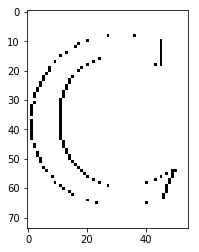

In [48]:
IMOutputEven=np.round((Vouteven)*norma)
IMOutput=np.zeros(shape)
IMOutput[1:-1:2]=(IMOutputEven[1:-1:2]>0)
IMOutput[0::2]=(IMOutputOdd[1::2]>0)
plt.imshow(IMOutput.reshape((im_crop.shape[0],im_crop.shape[1])), cmap='Greys')